In [17]:
import numpy as np

from system import (
    states,
    actions,
    num_states,
    num_actions,
    wind_col,
    to_idx,
    get_valid_actions,
    init_mdp,
    init_reward,
    rows,
    cols,
)

from model import Model
from policy import Policy, PolicyInit

In [74]:
def Contraction(valf: np.ndarray, model: Model, gamma=1.0):
    delta = 0
    for s in states:
        v = valf[to_idx(s)]
        valid_actions_idx = get_valid_actions(s, idx=True)
        valf[to_idx(s)] = np.max(
            [
                model.prob(s, a) @ (model.get_reward(s) + gamma * valf)
                for a in valid_actions_idx
            ]
        )
        delta = max(delta, abs(v - valf[to_idx(s)]))
    return delta, valf

In [75]:
def GetPolicy(valf: np.ndarray, model: Model, gamma=1.0):
    policy = Policy(num_states, num_actions, PolicyInit.ZERO)

    for s in states:
        valid_actions_idx = get_valid_actions(s, idx=True)
        action_value = [
            model.prob(s, a) @ (model.get_reward(s) + gamma * valf)
            for a in valid_actions_idx
        ]
        amzt = valid_actions_idx[np.argmax(action_value)]
        policy.update(s, amzt, 1)
        policy.set_action(s, amzt)
    return policy

In [81]:
# Initialize model
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=0)
model = Model(mdp, reward)

In [82]:
valf = np.zeros(num_states)
# valf[to_idx(t_state)] = 0

thresh = 0.001
gamma = 0.9

delta = thresh + 1
i = 0

while delta > thresh and i < 1000:
    print(f"Value Iteration {i + 1}")

    # Apply contraction mapping
    delta, valf = Contraction(valf, model, gamma=gamma)

    # Print delta
    print(f"Delta: {delta}")
    i+=1

policy = GetPolicy(valf, model)

Value Iteration 1
Delta: 2.2808889999999997
Value Iteration 2
Delta: 1.6196666666666668
Value Iteration 3
Delta: 1.2960000000000003
Value Iteration 4
Delta: 1.1664000000000003
Value Iteration 5
Delta: 1.049760000000001
Value Iteration 6
Delta: 0.9447840000000003
Value Iteration 7
Delta: 0.8503056000000004
Value Iteration 8
Delta: 0.7652750400000006
Value Iteration 9
Delta: 0.6887475360000002
Value Iteration 10
Delta: 0.6198727824000008
Value Iteration 11
Delta: 0.5578855041600006
Value Iteration 12
Delta: 0.5020969537440001
Value Iteration 13
Delta: 0.45188725836960053
Value Iteration 14
Delta: 0.30396488662492516
Value Iteration 15
Delta: 0.2287679245496097
Value Iteration 16
Delta: 0.20589113209465015
Value Iteration 17
Delta: 0.18530201888518505
Value Iteration 18
Delta: 0.16677181699666477
Value Iteration 19
Delta: 0.1500946352969983
Value Iteration 20
Delta: 0.13508517176729917
Value Iteration 21
Delta: 0.12157665459056943
Value Iteration 22
Delta: 0.10941898913151249
Value Iterat

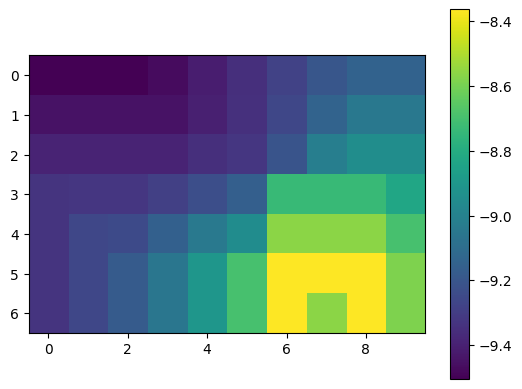

In [83]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

In [89]:
# Run agent
score = 0
steps = 0
s = np.array([3,0])

path = [s]

while(steps < 1000):
    a = policy.get_action(s)

    s_ = model.gen_next(s, a)
    path.append(s_)

    r = model.get_reward(s, s_)
    score += r
    print(f"State: {s}, Action: {actions[a]}, Next State: {s_}, Reward: {r}")

    if(r!= -1):
        print(f"Game Over - Score: {score}")
        break
    
    s = s_
    steps += 1

State: [3 0], Action: [1 1], Next State: [4 1], Reward: -1
State: [4 1], Action: [1 1], Next State: [5 2], Reward: -1
State: [5 2], Action: [1 1], Next State: [6 3], Reward: -1
State: [6 3], Action: [0 1], Next State: [4 4], Reward: -1
State: [4 4], Action: [1 1], Next State: [3 5], Reward: -1
State: [3 5], Action: [1 1], Next State: [3 6], Reward: -1
State: [3 6], Action: [1 1], Next State: [3 7], Reward: 0
Game Over - Score: -6


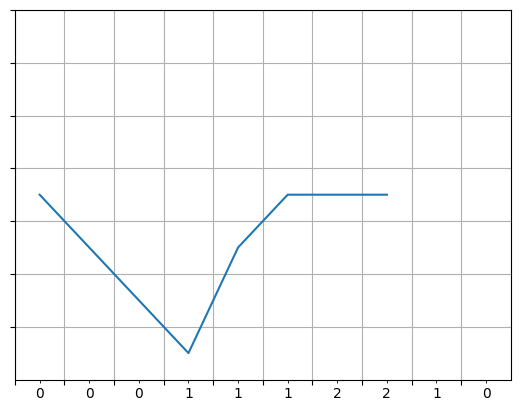

In [90]:
path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()